## Anaylsis of top10 configurations 
Configurations are based on results from the grep gridsearch using the TVAE model

In [33]:
import json

# Load the JSON file
with open('c3o_TVAE_grep.json', 'r') as f:
    data = json.load(f)

# Extract the score and configuration for each configuration
scores = [config['score'] for config in data]
configurations = [config['combination'] for config in data]

# Sort the configurations by score in descending order
sorted_scores = sorted(scores, reverse=True)
sorted_configurations = [configurations[scores.index(score)] for score in sorted_scores]

# Get the top 10 configurations with the highest score
top_ten_sorted_scores = sorted_scores[:10]
top_10_configurations = sorted_configurations[:10]

In [26]:
import pandas as pd

# Read the CSV file with header column
df = pd.read_csv('c3o_TVAE_top10.csv', header=0)
df = df.drop(df.columns[0], axis=1)
# Set the index to start at 1
df.index = range(1, len(df) + 1)

# Print the DataFrame
print(df)

        grep    kmeans  pagerank       sgd      sort
1   0.911948  0.925249  0.913196  0.924990  0.903041
2   0.922661  0.917037  0.899780  0.920938  0.905524
3   0.904982  0.934166  0.873571  0.926601  0.902151
4   0.926766  0.914764  0.889468  0.905960  0.923244
5   0.900950  0.896570  0.895888  0.908918  0.898051
6   0.912803  0.903314  0.905278  0.906091  0.880216
7   0.908650  0.921917  0.907428  0.929522  0.893714
8   0.925440  0.915637  0.899699  0.898408  0.915505
9   0.898328  0.902262  0.898585  0.929226  0.897874
10  0.915311  0.916502  0.916690  0.930805  0.921164


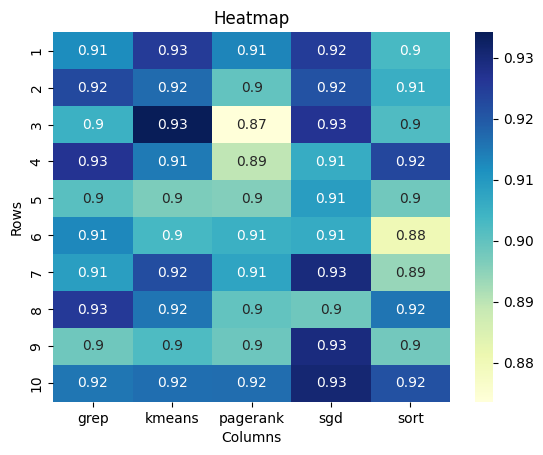

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using seaborn
sns.heatmap(df, cmap='YlGnBu', annot=True)

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap')

# Display the plot
plt.show()


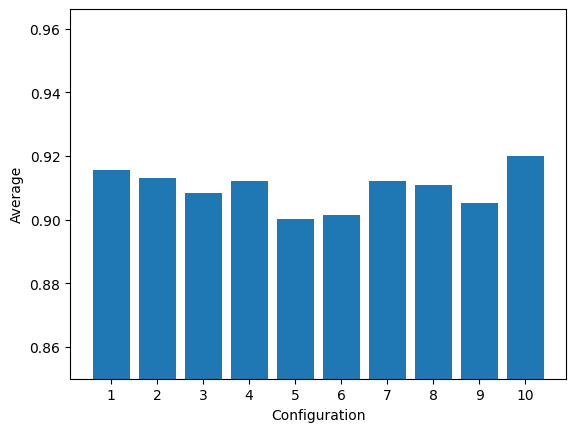

In [30]:
# Calculate the average row-wise
average_row = df.mean(axis=1)

# Create a bar plot using matplotlib
plt.bar(range(len(average_row)), average_row)

# Customize the plot
plt.ylim(0.85, plt.ylim()[1])  # Set y-axis lower limit to 0.85
plt.xticks(range(len(average_row)), df.index)
plt.xlabel('Configuration')
plt.ylabel('Average')

# Display the plot
plt.show()

In [35]:
print(average_row)
print(top_10_configurations[9])

1     0.915685
2     0.913188
3     0.908294
4     0.912040
5     0.900075
6     0.901541
7     0.912246
8     0.910938
9     0.905255
10    0.920095
dtype: float64
{'enforce_min_max_values': True, 'enforce_rounding': True, 'epochs': 1500, 'batch_size': 200, 'compress_dims': [256, 256], 'decompress_dims': [256, 256], 'embedding_dim': 256, 'l2scale': 0.0001, 'loss_factor': 2}


## Analysis of best performing model
To reduce complexity we only use ''sort.tsv'' since it is the most challenging dataset, because it only contains 631 entries

In [1]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

file = 'sort'
data = pd.read_csv(f'c3o_data/{file}.tsv', sep='\t')

configuration = {'enforce_min_max_values': True, 'enforce_rounding': True, 'epochs': 1500, 'batch_size': 200, 'compress_dims': [256, 256], 'decompress_dims': [256, 256], 'embedding_dim': 256, 'l2scale': 0.0001, 'loss_factor': 2}

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=data)
metadata.validate()

synthesizer = TVAESynthesizer(
        metadata=metadata,
        enforce_min_max_values=configuration['enforce_min_max_values'],
        epochs=configuration['epochs'],
        batch_size=configuration['batch_size'],
        compress_dims=configuration['compress_dims'],
        decompress_dims=configuration['decompress_dims'],
        embedding_dim=configuration['embedding_dim'],
        l2scale=configuration['l2scale'],
        loss_factor=configuration['loss_factor']
    )

synthesizer.fit(data)
synthetic_data = synthesizer.sample(631)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
quality_report = evaluate_quality(
        real_data=data,
        synthetic_data=synthetic_data,
        metadata=metadata
    )

Creating report: 100%|██████████| 4/4 [00:00<00:00, 110.39it/s]


Overall Quality Score: 91.44%

Properties:
Column Shapes: 89.48%
Column Pair Trends: 93.4%


In [3]:
data.head()

,instance_count,machine_type,slots,memory,data_size_MB,line_length,lines,gross_runtime
0,2,c4.2xlarge,16,30000,9530,1000,10000000,340
1,2,c4.2xlarge,16,30000,9530,1000,10000000,348
2,2,c4.2xlarge,16,30000,9530,1000,10000000,352
3,2,c4.2xlarge,16,30000,9530,1000,10000000,352
4,2,c4.2xlarge,16,30000,9530,1000,10000000,360


In [4]:
synthetic_data.head()

,instance_count,machine_type,slots,memory,data_size_MB,line_length,lines,gross_runtime
0,6,c4.2xlarge,48,99121,11590,101,118234830,154
1,8,m4.2xlarge,64,262236,17370,100,196337971,236
2,12,c4.2xlarge,96,100625,9657,100,105309515,181
3,2,c4.2xlarge,16,43193,13490,101,153058901,346
4,6,r4.2xlarge,48,416385,13470,100,131434498,141


In [5]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,instance_count,KSComplement,0.944268
1,slots,KSComplement,0.936344
2,memory,KSComplement,0.884663
3,data_size_MB,KSComplement,0.868236
4,line_length,KSComplement,0.813222
5,lines,KSComplement,0.855105
6,gross_runtime,KSComplement,0.936143
7,machine_type,TVComplement,0.920232


In [6]:
quality_report.get_visualization(property_name='Column Shapes')

In [7]:
quality_report.get_visualization(property_name='Column Pair Trends')

In [9]:
from sdmetrics.single_table import NewRowSynthesis

# Returns share of not-exact copies, 1 --> no exact copies
NewRowSynthesis.compute(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

1.0